###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2014 L.A. Barba, C.D. Cooper, G.F. Forsyth.  

# Iterate This!

In [Lesson 1](./2D_Laplace_Equation.ipynb) and [Lesson 2](./2D_Poisson_Equation.ipynb) of this module we used the Jacobi method to iteratively solve for solutions to elliptic PDEs.  

And it worked, so why are we still talking about it?  Because it's slow.  Very, very slow.  It might not have seemed that way in the first two notebooks because our domains were quite tiny, but consider this:  for a domain with $nx = ny = 128$, the Jacobi method will require nearly *20000* iterations before the steady state check reaches $10^{-8}$.

Using one core of an Intel i7 3.5 GHz processor, that takes around 3 seconds.  Now consider this:  an incompressible Navier Stokes solver has to ensure that the pressure field is divergence-free at every timestep.  One of the most common ways to ensure that the pressure field is divergence-free is to *relax* the pressure field using *iterative methods*!  

In fact, the pressure condition is responsible for the majority of the computational expense of a Navier Stokes solver.  And with the current set up, each timestep could require 3 seconds of CPU time just to satisfy the pressure constraints!  We'll grow old and die before we ever get cavity flow working!

There has to be a better way.  And, of course, there is.  There are several!


We'll be using the same example problem that we covered in [Lesson 1](./2D_Laplace_Equation.ipynb), with boundary conditions

\begin{equation}
  \begin{gathered}
p=0 \text{ at } x=0\\
\frac{\partial p}{\partial x} = 0 \text{ at } x = L\\
p = 0 \text{ at }y = 0 \\
p = \sin \left(  \frac{\frac{3}{2}\pi x}{L} \right) \text{ at } y = H
  \end{gathered}
\end{equation}

In [1]:
import numpy
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

Instead of copying and pasting cells that we wrote in [Lesson 1](), we have again created a 'helper' file that you can import some useful functions from.  

In [2]:
from laplace_helper import p_analytical, plot2D, L2_rel_error

Now we have the `p_analytical`, `plot2D`, and `L2_rel_error` functions in our namespace.  If you can't remember how they work, just use `help()` and take advantage of the docstrings.  

### Test Problem

We are going to use larger grid dimensions in this notebook to better illustrate the speed increases available with different iterative methods.  

In [3]:
nx = 128
ny = 128

L = 5
H = 5

x = numpy.linspace(0,L,nx)
y = numpy.linspace(0,H,ny)

dx = L/(nx-1)
dy = H/(ny-1)

p0 = numpy.zeros((ny, nx))

p0[-1,:] = numpy.sin(1.5*numpy.pi*x/x[-1])

First things first -- we said above that the Jacobi method takes nearly 20000 iterations before it satisfies the steady state target L2-norm of $10^{-8}$, but let's verify that.  

In [4]:
def laplace2d(p, y, dx, dy, l2_target):
    '''Solves the diffusion equation with forward-time, centered scheme
    
    Parameters:
    ----------
    p: 2D array of float
        Initial potential distribution
    y: array of float
        Nodal coordinates in y
    dx: float
        Mesh size
    dy: float
        Mesh size
    l2_target: float
        Error target
        
    Returns:
    -------
    p: 2D array of float
        Potential distribution after relaxation
    '''
    
    l2norm = 1
    pn = numpy.empty_like(p)
    iterations = 0

    while l2norm > l2_target:
        pn = p.copy()
        p[1:-1,1:-1] = .25 * (pn[1:-1,2:] + pn[1:-1,:-2] +\
                              pn[2:,1:-1] + pn[:-2,1:-1])
        
        ##Neumann B.C. along x = L
        p[1:-1,-1] = .25 * (2*pn[1:-1,-2] + pn[2:,-1] + pn[:-2, -1])
        
        l2norm = numpy.sqrt(numpy.sum((p - pn)**2)/numpy.sum(pn**2))
        iterations += 1
     
    return p, iterations

In [5]:
eps = 1e-8
p, iterations = laplace2d(p0.copy(), y, dx, dy, eps)

print ("Jacobi method took {} iterations at tolerance {}".\
        format(iterations, eps))

Jacobi method took 19993 iterations at tolerance 1e-08


Would we lie to you?  19993 iterations before the steady state check dips below $10^{-8}$.  

We can also time how long the Jacobi method takes using the `%%timeit` cell-magic.  This can take a little bit of time -- the `%%timeit` magic runs the function a few times and then averages their runtimes to give a more accurate result.  

<br>
<div class="alert alert-success">
Note also that when using `%%timeit`, the return values of a function (`p` and `iterations` in this case) *won't* be saved.
</div>

With those caveats, let's give it a shot:

In [6]:
%%timeit
laplace2d(p0.copy(), y, dx, dy, eps)

1 loops, best of 3: 5.47 s per loop


A little over 3 seconds.  Not terrible, but not great.  First let's check to see if it's even accurate by comparing it to the analytical solution.

In [7]:
pan = p_analytical(x,y)

In [8]:
L2_rel_error(p,pan)

6.1735513352973877e-05

Ok, that's a pretty small error.  Let's focus on speeding up the process.  

## Gauss-Seidel

You will recall from [Lesson 1](./2D_Laplace_Equation.ipynb) that a single Jacobi iteration is written as:

\begin{equation}
p^{n+1}_{i,j} = \frac{1}{4} \left(p^{n}_{i,j-1} + p^n_{i,j+1} + p^{n}_{i-1,j} + p^n_{i+1,j} \right)
\end{equation}

The Gauss-Seidel method is a simple tweak to this idea -- use updated values as soon as they are available.  

If you imagine that we progress through an array in the following order:

<img src="./figures/solvepath.svg" width=350>


Then you can see that the values $p^{n+1}_{i-1,j}$ and $p^{n+1}_{i,j-1}$ can be used to calculate $p^{n+1}_{i,j}$, so the iteration formula will now read as:

\begin{equation}
p^{n+1}_{i,j} = \frac{1}{4} \left(p^{n+1}_{i,j-1} + p^n_{i,j+1} + p^{n+1}_{i-1,j} + p^n_{i+1,j} \right)
\end{equation}

But there's a problem.  You can't use NumPy's array operations to evaluate that.  Since Gauss-Seidel requires using values immediately after they're updated, we have to abandon our beloved array operations and return to nested `for` loops.  

That's not ideal, but if it saves us a bunch of time, then we can manage.  

In [9]:
def laplace2d_gauss_seidel(p, y, dx, dy, nx, ny, eps):
    
    iterations = 0
    error = 2*eps
    
    while error > eps:
        pn = p.copy()
        error = 0.0
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                p[j,i] = .25 * (p[j,i-1] + p[j,i+1] + p[j-1,i] + p[j+1,i])
                error += (p[j,i] - pn[j,i])**2
        
        #Neumann 2nd-order BC
        for j in range(1,ny-1):
            p[j,-1] = .25 * (2*p[j,-2] + p[j+1,-1] + p[j-1, -1])
            
        error = numpy.sqrt(error/numpy.sum(pn**2))
        iterations += 1        
        
    return p, iterations

And then we would run this via:

```Python
p, iterations = laplace2d_gauss_seidel(p, y, dx, dy, nx, ny, 1e-8)
```

<br>
But **don't do it**.  We did it so that you don't have to.  

The Gauss-Seidel method required several thousand fewer iterations than the traditional Jacobi method for this example, but it took more than *7 minutes* to run.  

And we were complaining about 3 seconds!?

##### What happened?

If you think back to the far off days when you first learned about array operations, you might recall that we discovered that NumPy array operations could drastically improve code performance compared with nested `for` loops.  NumPy operations are largely written in compiled C code and they are *much* faster than vanilla Python.  But the Jacobi method is old and while 3 seconds is much better than 7 minutes, it's still too slow.  What can we do?

## Use Numba!

Numba is a Just-In-Time (JIT) compiler for Python.  It takes a chunk of Python, converts it into optimized machine code, then compiles it and runs it.  

It can massively speed up performance, especially when dealing with loops.  Plus, it's pretty easy to use!  

<div class="alert alert-success">
<h5>Caveat</h5>
<br>

We encourage everyone following the course to use the Anaconda Python distribution because it's well put-together and simple to use.  If you *haven't* been using Anaconda, that's fine, but let us **strongly** suggest that you take the plunge now.  Numba is great and easy to use, but it is **not** easy to install without help.  Those of you using Anaconda can install it by running <br><br>

`conda install numba`<br><br>

If you *really* don't want to use Anaconda, you can find instructions on how to compile Numba's dependencies [here](https://pypi.python.org/pypi/numba)


</div>

### Intro to Numba

Time to dive in!  Numba is great and easy to use.  We're going to walk you through a simple example first to give you a taste of Numba's abilities.  

First, let's import `numba` and also import `autojit` (more on this in a bit).

In [10]:
import numba
from numba import autojit

You tell Numba which functions you want to accelerate by using Python decorators.  Let's write a quick function that calculates the $n$th number in the Fibonacci sequence.

In [11]:
def fibit(n):
    a = 1
    b = 1
    for i in range(n-2):
        a, b = b, a+b
        
    return b

There are several faster ways to program the Fibonacci sequence, but that's not a concern right now (but if you're curious, check [this](http://mathworld.wolfram.com/BinetsFibonacciNumberFormula.html) out).  Let's use `%%timeit` and see how long this simple function takes to find the 500,000th Fibonacci number.

In [12]:
%%timeit
fibit(500000)

1 loops, best of 3: 3.68 s per loop


Around 2.5 seconds on one of our machines.  Now let's try Numba!  Just add the `@autojit` decorator above the function name and let's see what happens!

In [13]:
@autojit
def fibit(n):
    a = 1
    b = 1
    for i in range(n-2):
        a, b = b, a+b
        
    return b

In [14]:
%%timeit
fibit(500000)

The slowest run took 256.17 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 3: 416 µs per loop


Holy cow!  That warning from `%%timeit` is due to the compilation overhead for Numba.  The very first time that it runs, it has to compile the generated machine code, then it caches that code for reuse without extra compiling.  That's the 'Just=In-Time' bit.  You'll see it disappear if we run `%%timeit` again.

In [15]:
%%timeit
fibit(500000)

1000 loops, best of 3: 675 µs per loop


Yes this is a slightly contrived example, but that's a 10000x increase in speed!  For one line!!!

### `nopython` mode

Numba is very clever, but it can't optimize everything.  When it can't, rather than failing to run, it will fall back to the regular Vanilla Python that we decided is far too slow.  This can be frustrating, since you might not know which bits of code will speed up and which bits won't.  

To avoid this particular annoyance, you can tell Numba to use `nopython` mode.  This will raise an exception if there is code that can't be optimized in a function.  

One quick example -- a great deal of Numpy functionality is available within Numba accelerated functions, but not everything is there.  Consider the function below that makes a copy of an array and then adds one to every value.  It's a silly function, but it will run.  

In [16]:
def increment_array(x):
    a = x.copy()
    a += 1
    
    return a

In [17]:
x = numpy.random.random(10)
a = increment_array(x)
print(x)
print(a)

[ 0.05156428  0.43476594  0.37633964  0.01557615  0.55787938  0.97719989
  0.97559595  0.14993012  0.30889571  0.41882588]
[ 1.05156428  1.43476594  1.37633964  1.01557615  1.55787938  1.97719989
  1.97559595  1.14993012  1.30889571  1.41882588]


However, in-place addition isn't supported for arrays within Numba using `nopython` mode.  It will still compile and run, but it might cause a slowdown.  Instead, we can tell Numba to use `nopython` mode.  

In [18]:
@autojit(nopython=True)
def increment_array(x):
    a = x.copy()
    a += 1
    
    return a

In [19]:
a = increment_array(x)

If you scroll all the way down to the bottom of that error message, you'll see this

```
LoweringError: Failed at nopython (nopython mode backend)
Internal error:
NotImplementedError: inplace_binop(rhs=$const0.5, lhs=a, fn=+)
File "<ipython-input-59-de847f90b64c>", line 4
```

That's Numba telling us that there's a problem on line 4 if we want everything to be accelerated.  We can get around this by removing the in-place operation.

In [20]:
@autojit(nopython=True)
def increment_array(x):
    a = x.copy()
    a = a + 1
    
    return a

In [21]:
a = increment_array(x)

Now we know that the function runs and will be accelerated as much as Numba can manage.  Onwards!

<div class="alert alert-danger">
<h5>Numba version check</h5>
<br>

If the "fixed" version of `increment_array` still doesn't work then you need to upgrade your version of Numba to at least 0.20.


</div>

## Back to Jacobi

We want to compare different iterative methods and to do so, we need to make sure we aren't introducing other factors in to these comparisons.  First things first, we want to write a new Jacobi method solver that uses Numba instead of Numpy so we have a proper baseline to compare against.

In [22]:
from numba import jit

In [23]:
@jit(nopython=True)
def laplace2d_jacobi(p, pn, y, dx, dy, eps):
    
    iterations = 0
    error = 2*eps
    ny, nx = p.shape
    l2err = numpy.zeros(30000)
    
    while error > eps:
        for j in range(ny):
            for i in range(nx):
                pn[j,i] = p[j,i]
        error = 0.0
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                p[j,i] = .25 * (pn[j,i-1] + pn[j,i+1] + pn[j-1,i] + pn[j+1,i])
                
        
        #Neumann 2nd-order BC
        for j in range(1,ny-1):
            p[j,-1] = .25 * (2*pn[j,-2] + pn[j+1,-1] + pn[j-1, -1])
            
            
        for j in range(ny):
            for i in range(nx):
                error += (p[j,i] - pn[j,i])**2
        
        
        error = numpy.sqrt(error/numpy.sum(pn**2))
        l2err[iterations] = error
        iterations += 1    
        
    return p, iterations, l2err

In [24]:
p, iterations, l2errJ = laplace2d_jacobi(p0.copy(), p0.copy(), y, dx, dy, 1e-8)

print("Numba Jacobi method took {} iterations at tolerance {}".format(iterations, eps))

Numba Jacobi method took 19993 iterations at tolerance 1e-08


That's actually a little bit slower than the Numpy version of the Jacobi solver, but don't lose heart!  Remember that Numpy is a highly optimized library.  The fact that we're even remotely close to the same execution time with this JIT-compiled code is kind of amazing.  Plus(!) now we get to try out those techniques that aren't possible with Numpy array operations.

<div class="alert alert-success">
<h5>Note</h5>
<br>

We're also saving the history of how the L2-norm changes over the course of these iterations.  We'll take a look at those once we have a few more methods to compare it to.


</div>

## Back to Gauss-Seidel

If you recall, the whole reason we got into this Numba sidetrack was to try out Gauss-Seidel.  Recall from above that the formula for Gauss-Seidel is as follows:

\begin{equation}
p^{n+1}_{i,j} = \frac{1}{4} \left(p^{n+1}_{i,j-1} + p^n_{i,j+1} + p^{n+1}_{i-1,j} + p^n_{i+1,j} \right)
\end{equation}

That means we only need to ever so slightly tweak the Jacobi solver to implement Gauss-Seidel.  Instead of updating `p` in terms of `pn`, we just update `p` using `p`.

In [25]:
@autojit(nopython=True)
def laplace2d_gauss_seidel(p, pn, y, dx, dy, eps):

    iterations = 0
    error = 2*eps
    ny, nx = p.shape
    l2err = numpy.zeros(30000)
    
    while error > eps:
        for j in range(ny):
            for i in range(nx):
                pn[j,i] = p[j,i]
        error = 0.0
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                p[j,i] = .25 * (p[j,i-1] + p[j,i+1] + p[j-1,i] + p[j+1,i])
                
        
        #Neumann 2nd-order BC
        for j in range(1,ny-1):
            p[j,-1] = .25 * (2*p[j,-2] + p[j+1,-1] + p[j-1, -1])
            
            
        for j in range(ny):
            for i in range(nx):
                error += (p[j,i] - pn[j,i])**2
        
        
        error = numpy.sqrt(error/numpy.sum(pn**2))
        l2err[iterations] = error
        iterations += 1    
        
    return p, iterations, l2err

In [26]:
p, iterations, l2errGS = laplace2d_gauss_seidel(p0.copy(), p0.copy(), y, dx, dy, 1e-8)

print("Numba Gauss-Seidel method took {} iterations at tolerance {}".format(iterations, eps))

Numba Gauss-Seidel method took 13939 iterations at tolerance 1e-08


Cool!  Using the most recently updated values saved 6000 iterations!

## Successive Over-Relaxation (SOR)

Successive over-relaxation is an extension of the Gauss-Seidel method.  We take the existing Gauss-Seidel method and use a linear combination of the previous and the current solution to accelerate convergence.  

\begin{equation}
p^{n+1}_{i,j} = (1 - \omega)p^n_{i,j} + \frac{\omega}{4} \left(p^{n+1}_{i,j-1} + p^n_{i,j+1} + p^{n+1}_{i-1,j} + p^n_{i+1,j} \right)
\end{equation}

SOR iterations are only stable for $0 < \omega < 2$.  

If $\omega < 1$, that is technically an "under-relaxation" and it will be slower than Gauss-Seidel.  

If $\omega > 1$, that's the over-relaxation and it should converge faster than Gauss-Seidel.  

Also note that for $\omega = 1$, the equation collapses into the Gauss-Seidel method.  


In [27]:
@autojit(nopython=True)
def laplace2d_SOR(p, pn, y, dx, dy, eps, omega):
    
    iterations = 0
    error = 2*eps
    ny, nx = p.shape
    l2err = numpy.zeros(20000)
    
    while error > eps:
        for j in range(ny):
            for i in range(nx):
                pn[j,i] = p[j,i]
        error = 0.0
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                p[j,i] = (1-omega)*p[j,i] + omega*.25 * (p[j,i-1] + p[j,i+1] + p[j-1,i] + p[j+1,i])
        
        #Neumann 2nd-order BC
        for j in range(1,ny-1):
            p[j,-1] = .25 * (2*p[j,-2] + p[j+1,-1] + p[j-1, -1])
            
        for j in range(ny):
            for i in range(nx):
                error += (p[j,i] - pn[j,i])**2
            
        error = numpy.sqrt(error/numpy.sum(pn**2))
        l2err[iterations] = error
        iterations += 1        
        
    
    return p, iterations, l2err

That wasn't too bad at all.  Let's try this out first with $\omega = 1$ and make sure it matches the Gauss-Seidel results from above.  

In [28]:
eps = 1e-8
omega = 1
p, iterations, l2errSOR = laplace2d_SOR(p0.copy(), p0.copy(), y, dx, dy, eps, omega)

print("Numba SOR method took {} iterations\
 at tolerance {} with omega = {}".format(iterations, eps, omega))

Numba SOR method took 13939 iterations at tolerance 1e-08 with omega = 1


We have the exact same number of iterations as Gauss-Seidel.  That's a good sign that things are working as expected.  

Now let's try to over-relax the solution and see what happens.  To start, let's try $\omega = 1.5$.

In [29]:
eps = 1e-8
omega = 1.5
p, iterations, l2errSOR = laplace2d_SOR(p0.copy(), p0.copy(), y, dx, dy, eps, omega)

print("Numba SOR method took {} iterations\
 at tolerance {} with omega = {}".format(iterations, eps, omega))

Numba SOR method took 7108 iterations at tolerance 1e-08 with omega = 1.5


Wow!  That really did the trick!  We dropped from 13939 iterations down to 7108.  Now we're really cooking!

### Tuned SOR

We picked $\omega=1.5$ somewhat arbitrarily.  Ideally, we would like to over-relax the solution as much as possible without introducing instability, as that will give us the fewest number of iterations.  

For square domains, it turns out that the ideal factor $\omega$ can be computed as a function of the number of nodes in one direction, e.g. `nx`.  

\begin{equation}
\omega \approx \frac{2}{1+\frac{\pi}{nx}}
\end{equation}

This is not some arbitrary formula, but its derivation lies outside the scope of this class.  For now, let's try it out and see how it works.  

In [30]:
eps = 1e-8
omega = 2./(1 + numpy.pi/nx)
p, iterations, l2errSOR = laplace2d_SOR(p0.copy(), p0.copy(), y, dx, dy, eps, omega)

print("Numba SOR method took {} iterations\
 at tolerance {} with omega = {:.4f}".format(iterations, eps, omega))

Numba SOR method took 1110 iterations at tolerance 1e-08 with omega = 1.9521


Wow!  That's *very* fast.  Also, $\omega$ is very close to the upper limit of 2.  SOR tends to work fastest when $\omega$ approaches 2, but don't be tempted to push it.  Set $\omega = 2$ and the walls will come crumbling down.  

How does the L2 error look with only 1110 iterations?

In [31]:
L2_rel_error(p,pan)

7.792743355076094e-05

Looking very good, indeed.  

We didn't explain it in any detail, but notice the very interesting implication of Equation $(5)$: the ideal relaxation factor is a function of the grid size.  

## L2 error reduction

Remember that in the [Poisson Equation notebook](02_2D_Poisson_Equation.ipynb) we noted that the steady state check seemed to "stall out" as the iterations progressed.  Clearly we have managed to reduce the number of iterations required to reach the desired accuracy -- now we can take a look at what happens to the error in these three methods as the iterations progress.

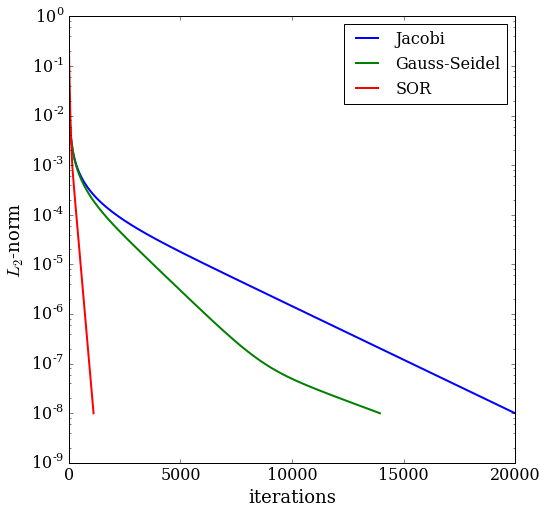

In [32]:
pyplot.figure(figsize=(8,8))
pyplot.xlabel(r'iterations', fontsize=18)
pyplot.ylabel(r'$L_2$-norm', fontsize=18)
pyplot.semilogy(numpy.trim_zeros(l2errJ,'b'),lw=2, label='Jacobi')
pyplot.semilogy(numpy.trim_zeros(l2errGS,'b'),lw=2, label='Gauss-Seidel')
pyplot.semilogy(numpy.trim_zeros(l2errSOR,'b'),lw=2, label='SOR')
pyplot.legend(fontsize=16);

That's the same sort of behavior we observed in [Lesson 2](./2D_Poisson_Equation.ipynb).  The Jacobi method starts out ok, but then it sort of trails off.  Gauss-Seidel hangs in there a little bit longer, but then it also slows down.  But wow(!), SOR seems to work pretty well!

## References

1.  Thomas, James William. Numerical partial differential equations: conservation laws and elliptic equations. Vol. 3. Berlin: Springer, 1999.

2.  http://wiki.scipy.org/PerformancePython

3.  http://www.physics.buffalo.edu/phy410-505/2011/topic3/app1/index.html


In [33]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())